# Create frequent public transport stops analysis


This notebook describes the example for a process to retain bus stops points with frequent services in a city

### Method: Stop headway analysis using average frequencies of departure during day time

- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during daytime over departure for normal weekdays
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)


### Process:
1. set up study region GTFS analysis parameters (gtfs_config.py)  
2. load GTFS data into an UrbanAccess transit data frame
    - stops will be loaded limited within study region buffered bounding box
3. select a usual or representative one week during the feeds period that should fully capture the provided PT services in a city. 
    - a suitable "usual" week should contain at least 0.9 (default) of the total maximum of trips.
4. Stop headway analysis using average departure time during usual weekday (Monday-Friday) daytime (7am-7pm)


A handy guide to the format of GTFS fields is [here](https://developers.google.com/transit/gtfs/reference/#tripstxt)   
Previous working branch using SQL:

https://github.com/shiqin-liu/global-indicators/blob/phoenix/process/07_create_frequent_public_transport.ipynb  


In [115]:
#For UrbanAccess installation instructions see: https://udst.github.io/urbanaccess/installation.html

In [116]:
#conda install -c udst urbanaccess

In [117]:
import pandas as pd
import geopandas as gpd
import os
import time   
import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

import calendar
import datetime
from datetime import timedelta


import urbanaccess as ua

# module with functions to load GTFS data into dataframes
# revise based on origional load function from UrbanAccess, take out the add agency and route type features
import ua_load 

# module with functions to calculate the average headway during the timeframe over departure
import gtfs_headway_analysis as gha

from shapely.geometry import shape,Point, LineString, Polygon

%matplotlib inline


In [118]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [119]:
# set up study region GTFS config
# these gtfs parameters are defined in gtfs_config.py file
GTFS = {'barcelona' : {'gtfs_filename':'gtfs_input_data/gtfs_spain_barcelona',
                   'gtfs_provider' : 'TMB',
                   'gtfs_year' : '2019',
                   'start_date_mmdd' : '20191001',
                   'end_date_mmdd' : '20201101',
                   'bbox' : (2.0822008749659653, 41.31251726667463, 2.2342770048946647, 41.47251143638445),
                   'crs': 'epsg:25831',
                   'modes' : {
                       'bus' : {'route_types': [3],
                                 'day_time' : ['07:00:00', '19:00:00'],
                                 'intervals': 30,
                                'agency_id': None},
                       'tram':{'route_types': [0],
                               'day_time' : ['07:00:00', '19:00:00'],
                               'intervals': 30,
                               'agency_id': None},
                       'train':{'route_types': [1,2],
                               'day_time' : ['07:00:00', '19:00:00'],
                               'intervals': 30,
                               'agency_id': None},
                       'ferry':{'route_types': [4],
                               'day_time' : ['07:00:00', '19:00:00'],
                               'intervals': 30,
                               'agency_id': None}
                   }
                   }
       }
                    



In [120]:
# set up a study region config to run in this notebook
city = 'barcelona'

gtfsfeed_path = GTFS['{}'.format(city)]['gtfs_filename']
start_date=GTFS['{}'.format(city)]['start_date_mmdd']
end_date=GTFS['{}'.format(city)]['end_date_mmdd']

peak_hour = GTFS['{}'.format(city)]['modes']['bus']['day_time']
start_hour = peak_hour[0]
end_hour = peak_hour[1]
bbox = GTFS['{}'.format(city)]['bbox']
crs = GTFS['{}'.format(city)]['crs']


headway_intervals = GTFS['{}'.format(city)]['modes']['bus']['intervals']
route_types = GTFS['{}'.format(city)]['modes']['bus']['route_types']
agency_ids = GTFS['{}'.format(city)]['modes']['bus']['agency_id']



# Load GTFS data into an UrbanAccess transit data frame

### Using UrbanAccess as source for:
- The settings object
- The feeds object and searching for GTFS feeds
- Loading GTFS data into a UrbanAccess transit data object


In [121]:
# revise based on origional function from UrbanAccess, take out the add agency and route type features
# we may want to limit the stops within the study region bounding box for efficiency, as some feeds are regional system
loaded_feeds = ua_load.gtfsfeed_to_df(gtfsfeed_path=gtfsfeed_path, validation=True, bbox=bbox, remove_stops_outsidebbox=True)

--------------------------------
GTFS text file header whitespace check completed. Took 2.00 seconds
--------------------------------
Processing GTFS feed: gtfs_spain_barcelona_AMB_20090617
Records: {}
     stop_id  stop_code                                        stop_name  \
0          1     109303                     Eusebi Güell - Joaquim Auger   
2          4     109239                                 Faigs - Julivert   
3          5     109244                                   Faigs - Freixe   
6         11       3047  Aeroport - Terminal T2-A B (Sentit Terminal T1)   
7         12     109198                             Terminal Aeroport T1   
...      ...        ...                                              ...   
3087    8677       9616                        Barcelona - Rius i Taulet   
3088    8678     110521                 Rosa Leveroni - Teresa Claramunt   
3090    8685     110523         Sant Martí de l'Erm - Av. Baix Llobregat   
3093    8692     110527               

### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

Quickly view the transit stop locations

In [134]:
len(loaded_feeds.stops)

1833

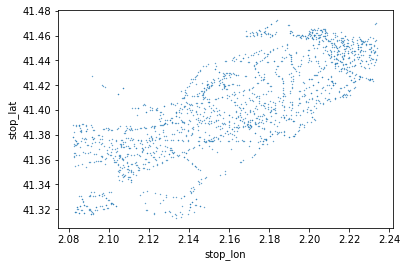

In [123]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)


# Select usual and representative one week for feeds analysis


In [124]:
# drive usual week starting Monday
# ensured that all weekdays have at least 90% of the maximum number of 
# daily PT trips during the time span of the week-long extract.
daily_trip_counts = gha.get_trip_counts_per_day(loaded_feeds)


In [125]:
usual_start_date = gha.get_weekly_extract_start_date(daily_trip_counts, weekdays_at_least_of_max=0.9, start_date=start_date, end_date=end_date)
usual_start_date


Timestamp('2020-03-23 00:00:00')

In [126]:
daily_trip_counts = daily_trip_counts[(daily_trip_counts.date >= start_date) & (daily_trip_counts.date <= end_date)]

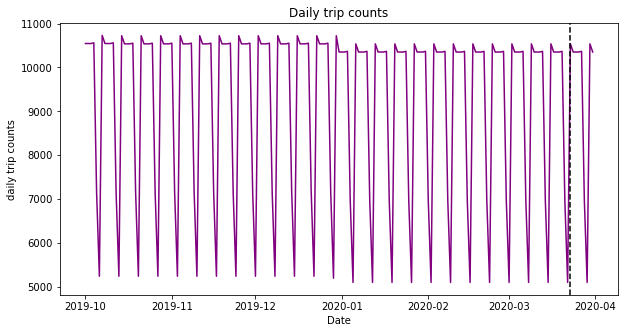

In [127]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 5))

# Add x-axis and y-axis
ax.plot(daily_trip_counts.sort_values('date')['date'],
        daily_trip_counts.sort_values('date')['trip_counts'],
        color='purple')

plt.axvline(x=usual_start_date, color='k', linestyle='--')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="daily trip counts",
       title="Daily trip counts")

plt.show()

Reference: [Kujala et. al. (2018) A collection of public transport network data sets for 25 cities](https://www.nature.com/articles/sdata201889#Sec21)  
"The dates for the temporal filtering were chosen based on the number of daily trips of the included feeds. We ensured that there was a clear weekly periodicity in the feeds, so that working days have roughly the same number of trips and that weekends have a different schedule. Then we selected the dates for the week-long and day-long extracts, where we aimed for a typical work week without major exceptions in the PT operations, such as national holidays. To this end, we ensured that all weekdays have at least 90% of the maximum number of daily PT trips during the time span of the week-long extract."

# Stop headway analysis using average departure time dur weekday daytime

- Identify feeds start and end dates that that a stop is a 30-minute frequency stop  
- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during the timeframe over departure
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)

In [128]:
# set the start and end date to usual week of weekday operation (Monday to Friday)
start_date = usual_start_date
end_date = usual_start_date + timedelta(4)

In [129]:
dow=['monday','tuesday','wednesday','thursday','friday']

In [130]:
date_service_df = gha.set_date_service_table(loaded_feeds)

# limit within specified start and end date, and within weekdays
start_date_mmdd = pd.to_datetime(start_date, format='%Y%m%d')
end_date_mmdd = pd.to_datetime(end_date, format='%Y%m%d')

date_service_df = date_service_df[date_service_df['weekday'].isin(dow)
                                 ][(date_service_df['date'] >= start_date_mmdd)
                                   & (date_service_df['date'] <= end_date_mmdd)].drop_duplicates()
#print('     ', len(date_service_df), ' unique service dates are identified within',
      #dow, ' from ', start_date, ' to ', end_date)


trips_routes = pd.merge(loaded_feeds.trips, loaded_feeds.routes, on='route_id', how='left')
# filter route trips based on valid services
valid_service_ids = date_service_df.service_id.unique()
trips_routes = trips_routes[trips_routes['service_id'].isin(valid_service_ids)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [131]:
date_service_df = date_service_df[date_service_df['weekday'].isin(dow)
                                 ][(date_service_df['date'] >= start_date_mmdd)
                                   & (date_service_df['date'] <= end_date_mmdd)].drop_duplicates()
date_service_df

,service_id,date,weekday
405,128.4.586,2020-03-23,monday
406,128.4.586,2020-03-24,tuesday
407,128.4.586,2020-03-25,wednesday
408,128.4.586,2020-03-26,thursday
409,128.4.586,2020-03-27,friday
...,...,...,...
107864,432.1.809,2020-03-23,monday
107865,432.1.809,2020-03-24,tuesday
107866,432.1.809,2020-03-25,wednesday
107867,432.1.809,2020-03-26,thursday


In [132]:
trips_routes = pd.merge(loaded_feeds.trips, loaded_feeds.routes, on='route_id', how='left')
# filter route trips based on valid services
valid_service_ids = date_service_df.service_id.unique()
trips_routes = trips_routes[trips_routes['service_id'].isin(valid_service_ids)]

In [133]:
trips_routes

,route_id,service_id,trip_id,direction_id,shape_id,wheelchair_accessible,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
99,128.4,128.4.586,128.4.1.3.0,0,128.4.1.3,1,1,86,Metro Horta - Albert Llanas,Información de ruta - www.ambmobilitat.cat,3,http://www.ambmobilitat.cat/Principales/TiraLi...,FFCC00,000000
100,128.4,128.4.586,128.4.1.3.1,0,128.4.1.3,1,1,86,Metro Horta - Albert Llanas,Información de ruta - www.ambmobilitat.cat,3,http://www.ambmobilitat.cat/Principales/TiraLi...,FFCC00,000000
101,128.4,128.4.586,128.4.1.3.2,0,128.4.1.3,1,1,86,Metro Horta - Albert Llanas,Información de ruta - www.ambmobilitat.cat,3,http://www.ambmobilitat.cat/Principales/TiraLi...,FFCC00,000000
102,128.4,128.4.586,128.4.1.3.3,0,128.4.1.3,1,1,86,Metro Horta - Albert Llanas,Información de ruta - www.ambmobilitat.cat,3,http://www.ambmobilitat.cat/Principales/TiraLi...,FFCC00,000000
103,128.4,128.4.586,128.4.1.3.4,0,128.4.1.3,1,1,86,Metro Horta - Albert Llanas,Información de ruta - www.ambmobilitat.cat,3,http://www.ambmobilitat.cat/Principales/TiraLi...,FFCC00,000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20545,395.1,395.1.44,395.1.2.1.16,1,395.1.2.1,1,44,N28,Collblanc - Pl. Catalunya - Port Olímpic,Información de ruta - www.ambmobilitat.cat,3,http://www.ambmobilitat.cat/Principales/TiraLi...,3366CC,FFFFFF
20546,395.1,395.1.44,395.1.2.1.17,1,395.1.2.1,1,44,N28,Collblanc - Pl. Catalunya - Port Olímpic,Información de ruta - www.ambmobilitat.cat,3,http://www.ambmobilitat.cat/Principales/TiraLi...,3366CC,FFFFFF
20547,395.1,395.1.44,395.1.2.1.18,1,395.1.2.1,1,44,N28,Collblanc - Pl. Catalunya - Port Olímpic,Información de ruta - www.ambmobilitat.cat,3,http://www.ambmobilitat.cat/Principales/TiraLi...,3366CC,FFFFFF
20548,395.1,395.1.44,395.1.2.1.19,1,395.1.2.1,1,44,N28,Collblanc - Pl. Catalunya - Port Olímpic,Información de ruta - www.ambmobilitat.cat,3,http://www.ambmobilitat.cat/Principales/TiraLi...,3366CC,FFFFFF


In [83]:
# filter trips within route types and agency id
if (route_types != None) & (agency_ids == None):
    trips_routes = trips_routes[(trips_routes['route_type'].isin(route_types))]
    date_service_df = date_service_df[date_service_df['service_id'].isin(trips_routes.service_id.unique())]
elif (route_types != None) & (agency_ids != None):
    trips_routes = trips_routes[(trips_routes['agency_id'].isin(agency_ids)) & (trips_routes['route_type'].isin(route_types))]
    date_service_df = date_service_df[date_service_df['service_id'].isin(trips_routes.service_id.unique())]
elif (route_types == None) & (agency_ids != None):
    trips_routes = trips_routes[(trips_routes['agency_id'].isin(agency_ids))]
    date_service_df = date_service_df[date_service_df['service_id'].isin(trips_routes.service_id.unique())]


In [85]:
date_service_df

,service_id,date,weekday


In [49]:
stops_headway = gha.get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date, 
                           end_date, route_types, agency_ids, 
                           dow=['monday','tuesday','wednesday','thursday','friday'])

     Zero trip is found within the specified start and end hours
     Zero stop is found within the specified timerange


/home/jovyan/work/Documents/GitHub/global-indicators/process/GTFS_freq_stop/gtfs_headway_analysis.py:294: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  & (date_service_df['date'] <= end_date_mmdd)].drop_duplicates()


In [ ]:
# select average departure headway less than or equal to maxi headway frequency intervals
stop_30_mins_headway = stops_headway[stops_headway['headway'] <= 20]

# get spatial features for freqent stops
stop_30_mins_final = pd.merge(stop_30_mins_headway, loaded_feeds.stops, how='left', on='stop_id')

# add stop id geometry
stop_30_mins_final['geometry'] = stop_30_mins_final.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
stop_30_mins_final = gpd.GeoDataFrame(stop_30_mins_final)

In [39]:
len(stop_30_mins_final)

2824

# Plot all PT stop and freqent PT bus stops

In [43]:
# get the study region boundary gdf
city = 'seattle'
region = 'us'
geopackagePath = '../data/input/{city}_{region}_2019_1600m_buffer.gpkg'.format(
        city=city, region=region)

# load shapefile and project to latlong for plotting with PT points
shape = gpd.GeoDataFrame.from_file(geopackagePath, 
              layer='urban_study_region')
shape_proj = ox.projection.project_gdf(shape, to_crs=None, to_latlong=True)


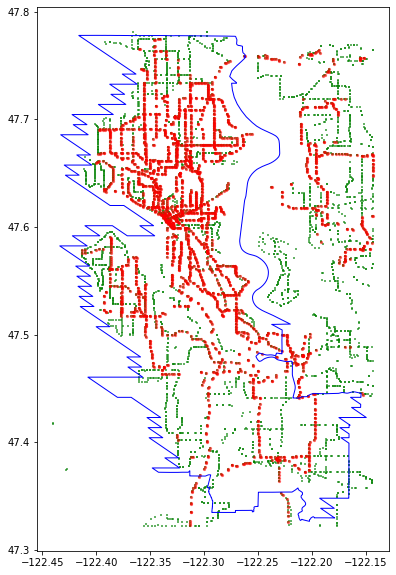

In [44]:
# set spatial geometry for all stops 
loaded_feeds.stops['geometry'] = loaded_feeds.stops.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
all_stops_gdf = gpd.GeoDataFrame(loaded_feeds.stops)

# plot the stops
fig, ax = plt.subplots(figsize=(10, 10))
ax = all_stops_gdf.plot(ax=ax, color='green', marker='+', markersize=5, alpha=0.6)
ax = stop_30_mins_final.plot(ax=ax, color='red', marker='o', markersize=5, alpha=0.5)
ax = shape_proj.plot(ax=ax, color='none', edgecolor='blue')

#ax.set_axis_off()

plt.show()